In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def loadDataTest(path):
    df = pd.read_csv(path)
#     df2 = df.drop(df.columns.difference(['Tweet_text']), axis=1)
#     df2.columns = ['Anootated tweet']
#     df2.reset_index(inplace=True, drop=True)
    
    return df

In [3]:
reviews = loadDataTest("Facebook_review_results.csv")

In [26]:
#adding column in the df for rating category
rating_category = []

for index, row in reviews.iterrows():
    if row['reviewer_ratings'] > 3:
        rating_category.append("positive")
    if row['reviewer_ratings'] < 3:
        rating_category.append("negative")
    if row['reviewer_ratings'] == 3:
        rating_category.append("neutral")
reviews['rating_category'] = rating_category
    

In [27]:
reviews

,Unnamed: 0,author_name,review_date,reviewer_ratings,review_body,rating_category
0,0,C P,"April 20, 2020",1,Facebook continues to create updates to colle...,negative
1,1,Natasha O'Neal,"April 20, 2020",3,Overall it's okay but there are a couple thin...,neutral
2,2,Adrionna Broyhill,"April 21, 2020",3,One star is because when I go on my uploads a...,neutral
3,3,Jean-lee De Beer,"April 20, 2020",5,"Hi, I have a slight problem, and I don't exac...",positive
4,4,Ben Shoptaugh,"April 20, 2020",1,When clicking a notification or comment it wi...,negative
5,5,Tyler McCann,"April 21, 2020",1,"This app has a lot of issues, most of which c...",negative
6,6,Kip Marzeck,"April 19, 2020",1,"Far too many unannounced updates, updates oft...",negative
7,7,Winifred Edna,"April 19, 2020",2,Everyone can visit: ( BrowserGood. Com ) to i...,negative
8,8,tashie's chimchim,"April 20, 2020",1,I dont know who decided on these new updates ...,negative
9,9,John M,"April 20, 2020",1,Notifications will appear but when I click on...,negative


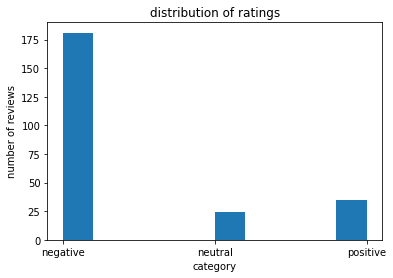

In [30]:
plt.hist(reviews['rating_category'])
plt.ylabel("number of reviews")
plt.xlabel("category")
plt.title("distribution of ratings")
plt.show()

In [ ]:
reviews = loadDataTest("Facebook_review_results.csv")